In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/google_drive', force_remount=True)
!unlink /content/drive
!ln -s /content/google_drive/MyDrive/ /content/drive

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/google_drive
unlink: cannot unlink '/content/drive': No such file or directory


In [ ]:
from os import chdir, environ
environ['TZ'] = 'US/Central'
!nvidia-smi

Sun Oct 17 18:57:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Starting Work**

In [ ]:
from os import chdir, environ
environ['TZ'] = 'US/Central'
chdir('/content/drive/PointCloud/')

In [ ]:
!ls -lt --time-style='+%y-%m-%d %H:%M:%S'

total 1458
drwx------ 2 root root    4096 21-10-18 09:57:06 scratch
-rw------- 1 root root   11190 21-10-18 09:56:52 model_attention.py
drwx------ 2 root root    4096 21-10-18 02:38:04 __pycache__
-rw------- 1 root root   10178 21-10-18 01:41:26 build_tree.py
-rw------- 1 root root   12386 21-10-17 16:20:03 model_arrange.py
-rw------- 1 root root    3727 21-10-15 12:55:04 build_tree.cpp
-rw------- 1 root root    9194 21-10-14 19:34:56 model.py
-rw------- 1 root root    2769 21-10-02 02:19:14 build_tree_basic.cpp
-rw------- 1 root root    7892 21-09-30 22:17:09 model_channel.py
drwx------ 2 root root    4096 21-09-24 10:52:59 old
drwx------ 3 root root    4096 21-09-23 18:24:21 datasets
-rw------- 1 root root     208 21-09-23 16:54:38 def.sh
-rw------- 1 root root 1416550 21-09-23 16:54:35 dev.out


**Experiment Init**

In [ ]:
import json
import h5py
import torch
import os
# from model import Encoder, init_logging
from model_attention import Encoder, init_logging
from build_tree import get_directions, init_directions
import logging

OUTPUT = 'scratch'
model_size = 2 ** 11
channel = 1
dim = 1024
basic = False
tree_arrange_rotate = True
prefix = "_basic" if basic else ""
sample_layers = 2
num_classes = 40
DATASET = './datasets/ModelNet40'
chaos_limit = 4 if not basic else 1
init_logging(OUTPUT)
_ = init_directions(chaos_limit)


2021-10-18 09:57:36 - INFO:	init_directions: # = 49
2021-10-18 09:57:36 - DEBUG:	0: 0.577350 0.577350 0.577350 otho = {37, 45, 14, 18, 22, 31}
2021-10-18 09:57:36 - DEBUG:	1: 0.666667 0.666667 0.333333 otho = {33, 36, 47, 19, 22}
2021-10-18 09:57:36 - DEBUG:	2: 0.707107 0.707107 0.000000 otho = {34, 35, 48, 20, 21, 22, 23, 24}
2021-10-18 09:57:36 - DEBUG:	3: 0.666667 0.666667 -0.333333 otho = {32, 40, 46, 15, 22}
2021-10-18 09:57:36 - DEBUG:	4: 0.577350 0.577350 -0.577350 otho = {39, 41, 10, 16, 22, 30}
2021-10-18 09:57:36 - DEBUG:	5: 0.666667 0.333333 0.666667 otho = {38, 44, 14, 23, 29}
2021-10-18 09:57:36 - DEBUG:	6: 0.816497 0.408248 0.408248 otho = {24, 33, 45, 38}
2021-10-18 09:57:36 - DEBUG:	7: 0.894427 0.447214 0.000000 otho = {36, 37, 38, 39, 40, 48}
2021-10-18 09:57:36 - DEBUG:	8: 0.816497 0.408248 -0.408248 otho = {32, 41, 20, 38}
2021-10-18 09:57:36 - DEBUG:	9: 0.666667 0.333333 -0.666667 otho = {38, 10, 42, 21, 25}
2021-10-18 09:57:36 - DEBUG:	10: 0.707107 0.000000 0.70710

In [ ]:
class Classifier(torch.nn.Module):
    def __init__(self, idim, odim):
        super(Classifier, self).__init__()
        self.relu = torch.nn.ReLU()

        self.linear1 = torch.nn.Linear(idim, idim // 2)
        self.bn1 = torch.nn.BatchNorm1d(idim // 2)

        self.linear2 = torch.nn.Linear(idim // 2, idim // 4)
        self.bn2 = torch.nn.BatchNorm1d(idim // 4)

        self.linear3 = torch.nn.Linear(idim // 4, odim)
        self.dropout = torch.nn.Dropout(0.7)

    def forward(self, ans):
        ans = self.linear1(ans)
        ans = self.bn1(ans)
        ans = self.relu(ans)

        ans = self.linear2(ans)
        ans = self.dropout(ans)
        ans = self.bn2(ans)
        ans = self.relu(ans)
        
        ans = self.linear3(ans)
        return ans

torch.manual_seed(674433238)
model = Encoder(model_size, sample_layers, dim, OUTPUT, channel=channel).cuda()
linear = Classifier(channel * dim, num_classes).cuda()

2021-10-18 09:57:50 - INFO:	self.N = 2048
2021-10-18 09:57:50 - INFO:	self.num_layers = 12
2021-10-18 09:57:50 - INFO:	self.sample_layers = 2
2021-10-18 09:57:50 - INFO:	layer 11 (leaf) # = 13860 odim = 8
2021-10-18 09:57:50 - INFO:	layer 10 (unsampled) # = 5741 odim = 16
2021-10-18 09:57:50 - INFO:	layer 9 (sampled) # = 2378 odim = 16
2021-10-18 09:57:50 - INFO:	layer 8 (sampled) # = 985 odim = 32
2021-10-18 09:57:50 - INFO:	layer 7 (sampled) # = 408 odim = 32
2021-10-18 09:57:50 - INFO:	layer 6 (sampled) # = 169 odim = 64
2021-10-18 09:57:50 - INFO:	layer 5 (sampled) # = 70 odim = 64
2021-10-18 09:57:50 - INFO:	layer 4 (sampled) # = 29 odim = 128
2021-10-18 09:57:50 - INFO:	layer 3 (sampled) # = 12 odim = 256
2021-10-18 09:57:50 - INFO:	layer 2 (sampled) # = 5 odim = 512
2021-10-18 09:57:50 - INFO:	layer 1 (sampled) # = 2 odim = 1024
2021-10-18 09:57:50 - INFO:	layer 0 (sampled) # = 1 odim = 1024


**Debug**

In [ ]:
pts = h5py.File(f'{DATASET}/train0.h5')['data'][0]
pts = torch.tensor(pts).cuda()
output = None

In [ ]:
pts = transform(pts.cuda()).cpu()

In [ ]:
tree = model.tree
pts, output, arrange = tree.arrange(pts, basic=basic, rotate=tree_arrange_rotate, debug=True, vec_per_point=4)

0
z_axis tensor([-0.4620, -0.2911, -0.8377], device='cuda:0')
z_axis z rotated tensor([1.4901e-08, 0.0000e+00, 1.0000e+00], device='cuda:0')
x_axis tensor([ 0.6849, -0.7286,  0.0000], device='cuda:0')
z_axis x rotated tensor([0., -0., 1.], device='cuda:0')
x_axis x rotated tensor([1.0000, 0.0000, 0.0000], device='cuda:0')
1
z_axis tensor([-0.2310, -0.9637,  0.1341], device='cuda:0')
z_axis z rotated tensor([0., 0., 1.], device='cuda:0')
x_axis tensor([ 0.7060, -0.7082,  0.0000], device='cuda:0')
z_axis x rotated tensor([0., -0., 1.], device='cuda:0')
x_axis x rotated tensor([1., 0., 0.], device='cuda:0')
2
z_axis tensor([ 9.7898e-01,  8.5105e-08, -2.0394e-01], device='cuda:0')
z_axis z rotated tensor([-1.2094e-09, -6.8749e-11,  1.0000e+00], device='cuda:0')
x_axis tensor([0.6996, 0.7146, 0.0000], device='cuda:0')
z_axis x rotated tensor([0., 0., 1.], device='cuda:0')
x_axis x rotated tensor([1., 0., 0.], device='cuda:0')
3
z_axis tensor([ 9.8200e-01, -1.9412e-08, -1.8888e-01], device='

In [ ]:
%matplotlib inline
def plot(points, color_layers=2, output=None):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.gridspec as gridspec
    import numpy as np

    points = points.cpu().numpy()
    x, y, z = points[:,0], points[:,1], points[:,2]
    x -= x.mean()
    y -= y.mean()
    z -= z.mean()

    color = np.array([0 for _ in range(x.shape[0])])
    
    def mark_color(z, last_ind=None):
        n = z.shape[0]
        ind = torch.tensor(z).sort()[1].numpy()
        indl, indr = ind[: n >> 1], ind[n >> 1 : ]
        if last_ind is not None:
            indl, indr = last_ind[indl], last_ind[indr]
        color[indr] += 1
        return indl, indr

    if output is not None:

        color = torch.tensor([0]).cuda()
        # print(tree.layer_size)
        for i, (layer, next_layer_size) in enumerate(zip(reversed(model.layers[1:]), tree.layer_size[1:])):
            next_color = torch.zeros(next_layer_size).long().cuda()
            if i < color_layers:
                color = color << 1
                right_add = 1
            else:
                right_add = 0
            assert layer.child_l.max() < next_layer_size
            assert layer.child_r.max() < next_layer_size
            next_color[layer.child_l] = color
            next_color[layer.child_r] = color + right_add
            color = next_color

        arrange = output[0]
        n = points.shape[0]
        color = np.array([color[arrange == i].max().item() for i in range(n)])

    elif color_layers >= 1:
        l, r = mark_color(z)
        if color_layers >= 2:
            color *= 2
            ll, lr = mark_color(y[l], l)
            rl, rr = mark_color(y[r], r)
            if color_layers >= 3:
                color *= 2
                for p in [ll, lr, rl, rr]:
                    mark_color(x[p], p)

    colormap = np.array(['red', 'blue', 'green', 'yellow', 'grey', 'orange', 'purple', 'cyan'])

    fig = plt.figure(dpi=80)
    gs = gridspec.GridSpec(nrows=2, ncols=4, left=0.1, right=2.5, wspace=0.05, hspace=0.05, bottom=0.1, top=1.3)
    for i in range(8):
        ax = fig.add_subplot(gs[i // 4, i % 4], projection='3d')

        x, y, z = points[:,0], points[:,1], points[:,2]
        labx, laby, labz = 'x', 'y', 'z'
        if (i & 4) != 0:    x = -x; labx = '-x'
        if (i & 2) != 0:    y = -y; laby = '-y'
        if (i & 1) != 0:    z = -z; labz = '-z'

        lmin = min(x.min(), y.min(), z.min())
        lmax = max(x.max(), y.max(), z.max())
        ax.scatter(x, y, z, c=colormap[color], marker='.')

        ax.set_xlim(lmin, lmax)
        ax.set_ylim(lmin, lmax)
        ax.set_zlim(lmin, lmax)

        ax.set_xlabel(labx)
        ax.set_ylabel(laby)
        ax.set_zlabel(labz) 
    plt.show()

    fig = plt.figure(dpi=80)
    ncolor = color.max() + 1
    nrows = max(1, ncolor // 4)
    ncols = min(ncolor, 4)
    gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, left=0.1, right=0.1 + 0.6 * ncols, wspace=0.05, hspace=0.05, bottom=0.1, top=0.1 + 0.6 * nrows)
    for i in range(ncolor):
        ax = fig.add_subplot(gs[i // 4, i % 4], projection='3d')

        p = points[color == i]
        x, y, z = p[:,0], p[:,1], p[:,2]

        lmin = min(x.min(), y.min(), z.min())
        lmax = max(x.max(), y.max(), z.max())
        ax.scatter(x, y, z, c=colormap[i], marker='.')

        ax.set_xlim(lmin, lmax)
        ax.set_ylim(lmin, lmax)
        ax.set_zlim(lmin, lmax)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z') 
    plt.show()

2021-10-18 03:14:13 - DEBUG:	Loaded backend module://ipykernel.pylab.backend_inline version unknown.


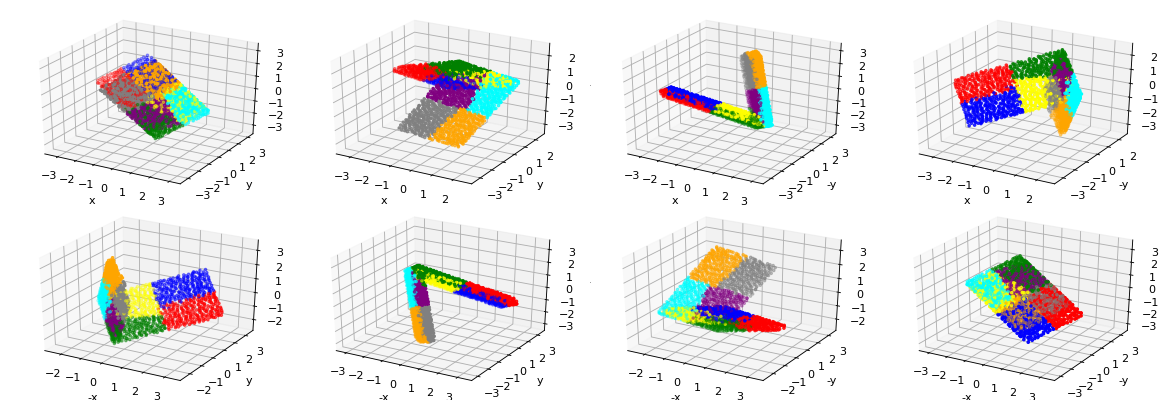

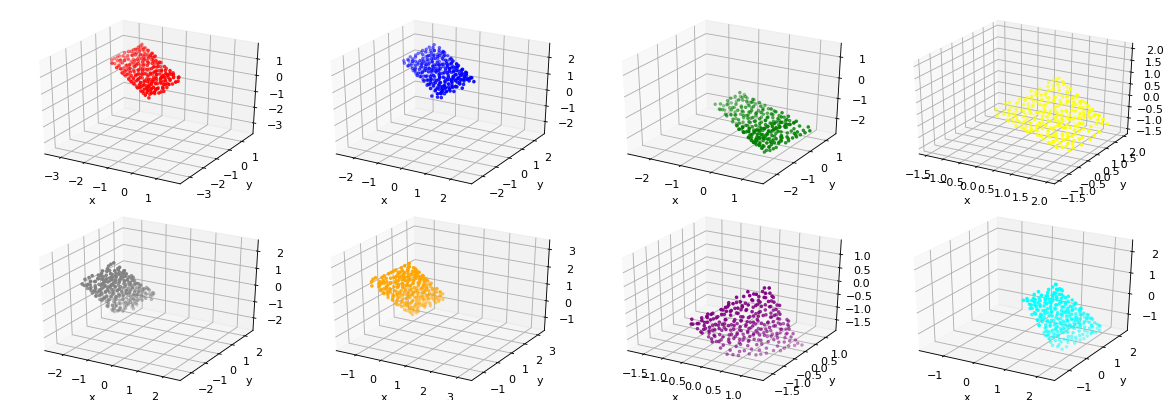

In [ ]:
plot(pts, 3, output=output)

In [ ]:
pts = train_data[7][0]
output = None

In [ ]:
for i in range(50):
    output, arrange = tree.arrange(pts, basic=basic, debug=False, device='cpu')

In [ ]:
batch_size = 64
_pts = pts.unsqueeze(0).expand(batch_size, 2048, 3)
_output = list(map(lambda x : x.unsqueeze(0).expand(batch_size, *x.shape), output))
feature = model(_pts, _output)

In [ ]:
feature.sum().backward()

In [ ]:
feature.shape

torch.Size([64, 512])

In [ ]:
for i in range(10):
    loss = model(pts.unsqueeze(0), list(map(lambda x : x.unsqueeze(0), output))).view(-1).sum()
    loss.backward()

In [ ]:
opt.zero_grad()

In [ ]:
for name, param in model.named_parameters():
    print(name, param.size())

In [ ]:
for name, param in model.named_parameters():
    if 'activate' in name:
        print(name, "\t", param.item())

In [ ]:
!cp /tmp/cppinput.txt scratch/

In [ ]:
!tail -n 5 /tmp/cppoutput.txt

**Data**

In [ ]:
from random import uniform
from math import acos, cos, sin
pi = acos(-1)

def get_random_transform(different=False):
    if different:
        return lambda points : get_random_transform()(points)

    scale = torch.randn(3).cuda()

    ox = uniform(0, 2 * pi)
    oy = uniform(0, 2 * pi)
    oz = uniform(0, 2 * pi)
    ox = torch.tensor([
        [1, 0, 0],
        [0, cos(ox), -sin(ox)],
        [0, sin(ox), cos(ox)]
    ]).float().cuda()
    oy = torch.tensor([
        [cos(oy), 0, -sin(oy)],
        [0, 1, 0],
        [sin(oy), 0, cos(oy)],
    ]).float().cuda()
    oz = torch.tensor([
        [cos(oz), -sin(oz), 0],
        [sin(oz), cos(oz), 0],
        [0, 0, 1]
    ]).float().cuda()
    axisperm = torch.randperm(3).cuda()
    axissgn = torch.tensor(-1).pow(torch.randint(low=0, high=2, size=[3])).cuda()

    affine = torch.nn.Linear(3, 3, bias=False).weight.detach().cuda()

    def transform(points):
        # points = points * scale
        # points = (points.matmul(ox).matmul(oy).matmul(oz) + torch.randn_like(points) * 1e-8)[:, axisperm] * axissgn
        points = points.matmul(affine)
        return points

    return transform

def make_data(points, label, transform=lambda x : x, basic_arrange=basic, debug=False):
    points = transform(torch.tensor(points).cuda())
    label = torch.tensor(label).squeeze().cuda().long()
    points, output, arrange = model.tree.arrange(points, basic=basic_arrange, rotate=tree_arrange_rotate, debug=debug)

    for j, val in enumerate(output):
        vmax = val.max().item()
        if vmax < 128:
            output[j] = val.char().cpu()
        else:
            assert vmax < 65536
            output[j] = val.short().cpu()

    assert arrange.max().item() < 65536
    points = points.cpu()
    label = label.cpu()
    arrange = arrange.short().cpu()

    assert 0 <= label.item() < num_classes
    return (points, output, arrange, label)

def process_data(data, source, save, basic_arrange=basic, transform=lambda x : x, debug=False):
    logging.info(f"Process data in {source} save in {save}")
    input_file = h5py.File(source)
    
    if data is None:
        data = []

    for i, (points, label) in enumerate(zip(input_file['data'], input_file['label'])):
        data.append(make_data(points, label, transform=transform, basic_arrange=basic, debug=debug))

        if (i + 1) % 10 == 0:
            logging.debug(f"convert {source}: #{i+1}")

    torch.save(data, save)
    return data

def remake_data(input, output=None):
    logging.info(f"Remake data in {input} save in {output}")
    data = torch.load(input)
    for i, (points, _, _, label) in enumerate(data):
        data[i] = make_data(points.cpu().numpy(), label.numpy())

        if (i + 1) % 10 == 0:
            logging.debug(f"convert input: #{i+1}")

    if output is not None:
        torch.save(data, output)
    return data

In [ ]:
transform = get_random_transform(True)
# transform = lambda x : x

In [ ]:
train_data = []
n_train = 5
for i in range(n_train):
    train_data = process_data(train_data, f'{DATASET}/train{i}.h5', f'{OUTPUT}/train_data{prefix}.pth', transform=transform)

In [ ]:
test_data = []
n_test = 2
for i in range(n_test):
    test_data = process_data(test_data, f'{DATASET}/test{i}.h5', f'{OUTPUT}/test_data{prefix}.pth', transform=transform)

In [ ]:
from random import shuffle, seed
raw_data = torch.load(f'{OUTPUT}/train_data{prefix}.pth')
n = len(raw_data)
perm = list(range(n))
seed(674433238)
shuffle(perm)
train_perm = perm[: -n//8]
valid_perm = perm[-n//8: ]
torch.save([train_perm, valid_perm], f'{OUTPUT}/train_split.pth')

In [ ]:
from_prefix = ""
assert from_prefix != prefix
_ = remake_data(f'{OUTPUT}/train_data{from_prefix}.pth', f'{OUTPUT}/train_data{prefix}.pth')
_ = remake_data(f'{OUTPUT}/test_data{from_prefix}.pth', f'{OUTPUT}/test_data{prefix}.pth')

**Train**

In [ ]:
raw_data = torch.load(f'{OUTPUT}/train_data{prefix}.pth')
n = len(raw_data)
train_perm, valid_perm = torch.load(f'{OUTPUT}/train_split.pth')
train_data = [raw_data[i] for i in train_perm]
valid_data = [raw_data[i] for i in valid_perm]
test_data = torch.load(f'{OUTPUT}/test_data{prefix}.pth')

In [ ]:
def make_batch(batches, eval=False):
    layers = 0
    points = []
    inputs = None
    labels = []
    for pts, output, arrange, label in batches:
        points.append(pts.cuda())
        labels.append(label.cuda())
        if inputs is None:
            layers = len(output)
            inputs = [[] for _ in output]

        for line, out in zip(inputs, output):
            line.append(out.cuda())

    points = torch.stack(points, dim=0).float().cuda()
    for i, line in enumerate(inputs):
        inputs[i] = torch.stack(line, dim=0).long().cuda()
    labels = torch.stack(labels, dim=0).long().cuda()
    
    return (points, inputs), labels

def evaluate(model, linear, test_data, noprint=False, perms=[None]):
    correct = 0
    total = 0

    if not noprint:
        logging.info(f"test_data # = {len(test_data)}")

    batch_size = 64
    print_epoch = 1

    model.eval()
    linear.eval()
    activate = lambda x : x

    for epoch in range(0, len(test_data), batch_size):
        input, label = make_batch(test_data[epoch : epoch + batch_size], eval=True)

        with torch.no_grad():
            for perm in perms:
                result = activate(linear(model(*input, perm=perm).contiguous().view(label.size(0), -1)))

                correct += (result.argmax(dim=-1) == label.cuda()).sum().item()
                total += label.size()[0]

        if not noprint:
            if (epoch // batch_size + 1) % print_epoch == 0:
                logging.debug(f"test #{epoch} correct = {'%.6lf' % (correct / total)}")

    if not noprint:
        logging.info(f"Done: score = {'%.8lf' % (correct / total)}")

    model.train()
    linear.train()  
    
    return correct / total

In [ ]:
from random import choice, randint
import build_tree
import torch

logging.info(f"train_data # = {len(train_data)}")

model.train()
linear.train()
activate = lambda x : x

cum_loss = 0

batch_size = 32 # 8 for attention, 32 for basic
batch_scale = 1 # 1 if basic else 1
epoch_scale = 8 # 4 if basic else 2
num_trans = 0


print_epoch = 20
valid_epoch = 100
epoch_since = 0
save_epoch = 1000
correct = 0
total = 0

threshold = -1.0

num_epoch = 100000

crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(list(model.parameters()) + list(linear.parameters()), lr=1e-4)
sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epoch / 5, eta_min=1e-5)

def get_trans(n=3):
    if n == 0:  return [None]
    return [randint(0, len(build_tree.transforms) - 1) for _ in range(n)]

torch.manual_seed(674433238)

for epoch in range(1, num_epoch + 1):

    for _ in range(epoch_scale):
        loss = 0.
        for _ in range(batch_scale):
            input, label = make_batch([choice(train_data) for _ in range(batch_size)])  
            for iperm in get_trans(num_trans):
                
                result = activate(linear(model(*input, perm=iperm).contiguous().view(batch_size, -1)))
                loss += crit(result, label.cuda())

                with torch.no_grad():
                    correct += (result.argmax(dim=-1) == label.cuda()).sum().item()
                    total += label.size()[0]
                    epoch_since += 1
        
        # assert loss.isnan().sum() == 0
        cum_loss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    sch.step()

    if cum_loss / epoch_since < threshold:
        epoch_scale, batch_scale = batch_scale, epoch_scale
        
        logging.info("Threshold Reached")
        threshold = -1e10
        
    if epoch <= 5 or epoch % print_epoch == 0:
        valid_str = ""
        func = logging.debug
        if epoch % valid_epoch == 0:
            vres = evaluate(model, linear, valid_data, noprint=True)
            valid_str = f"valid = {'%.6lf' % vres}"
            func = logging.info
        func(f"train #{epoch} lr = {'%.2e' % sch.get_last_lr()[0]} loss = {'%.6lf' % (cum_loss / epoch_since)} train = {'%.6lf' % (correct / total)} {valid_str}")
        epoch_since = cum_loss = correct = total = 0
    if epoch % save_epoch == 0:
        torch.save({
            'encoder': model.state_dict(),
            'linear': linear.state_dict()
        }, f"{OUTPUT}/trained_{epoch}.pth")

        tres = evaluate(model, linear, test_data, noprint=True)
        logging.info(f"Saved test = {'%.6lf' % tres}")


2021-10-18 03:55:04 - INFO:	train_data # = 8612
2021-10-18 03:55:05 - DEBUG:	train #1 lr = 1.00e-04 loss = 3.750878 train = 0.031250 
2021-10-18 03:55:07 - DEBUG:	train #2 lr = 1.00e-04 loss = 3.718564 train = 0.019531 
2021-10-18 03:55:08 - DEBUG:	train #3 lr = 1.00e-04 loss = 3.687017 train = 0.035156 
2021-10-18 03:55:09 - DEBUG:	train #4 lr = 1.00e-04 loss = 3.609766 train = 0.058594 
2021-10-18 03:55:10 - DEBUG:	train #5 lr = 1.00e-04 loss = 3.659607 train = 0.062500 
2021-10-18 03:55:27 - DEBUG:	train #20 lr = 1.00e-04 loss = 3.499044 train = 0.105208 
2021-10-18 03:55:50 - DEBUG:	train #40 lr = 1.00e-04 loss = 3.393783 train = 0.126758 
2021-10-18 03:56:13 - DEBUG:	train #60 lr = 1.00e-04 loss = 3.357378 train = 0.136328 
2021-10-18 03:56:36 - DEBUG:	train #80 lr = 1.00e-04 loss = 3.269618 train = 0.157812 
2021-10-18 03:57:01 - INFO:	train #100 lr = 1.00e-04 loss = 3.209073 train = 0.176367 valid = 0.113729
2021-10-18 03:57:24 - DEBUG:	train #120 lr = 1.00e-04 loss = 3.184681 t

KeyboardInterrupt: ignored

In [ ]:
for name, param in model.named_parameters():
    if "activate" in name:
        print(param.item(), name)

In [ ]:
torch.save({
    'encoder': model.state_dict(),
    'linear': linear.state_dict()
}, f"{OUTPUT}/trained.pth")

**Test**

In [ ]:
test_data = torch.load(f'{OUTPUT}/test_data.pth')

In [ ]:
ckpt = torch.load(f"{OUTPUT}/trained.pth")
model.load_state_dict(ckpt['encoder'])
linear.load_state_dict(ckpt['linear'])

<All keys matched successfully>

In [ ]:
evaluate(model, linear, valid_data, perms=[None])

2021-10-18 09:58:51 - INFO:	test_data # = 1231
2021-10-18 09:58:51 - DEBUG:	test #0 correct = 0.562500
2021-10-18 09:58:51 - DEBUG:	test #64 correct = 0.585938
2021-10-18 09:58:52 - DEBUG:	test #128 correct = 0.593750
2021-10-18 09:58:52 - DEBUG:	test #192 correct = 0.597656
2021-10-18 09:58:52 - DEBUG:	test #256 correct = 0.615625
2021-10-18 09:58:52 - DEBUG:	test #320 correct = 0.617188
2021-10-18 09:58:52 - DEBUG:	test #384 correct = 0.611607
2021-10-18 09:58:52 - DEBUG:	test #448 correct = 0.611328
2021-10-18 09:58:52 - DEBUG:	test #512 correct = 0.595486
2021-10-18 09:58:52 - DEBUG:	test #576 correct = 0.587500
2021-10-18 09:58:52 - DEBUG:	test #640 correct = 0.585227
2021-10-18 09:58:52 - DEBUG:	test #704 correct = 0.596354
2021-10-18 09:58:52 - DEBUG:	test #768 correct = 0.590144
2021-10-18 09:58:52 - DEBUG:	test #832 correct = 0.591518
2021-10-18 09:58:52 - DEBUG:	test #896 correct = 0.592708
2021-10-18 09:58:53 - DEBUG:	test #960 correct = 0.591797
2021-10-18 09:58:53 - DEBUG:

0.5970755483346872

In [ ]:
evaluate(model, linear, test_data, perms=[None])

2021-10-18 09:58:58 - INFO:	test_data # = 2468
2021-10-18 09:58:58 - DEBUG:	test #0 correct = 0.578125
2021-10-18 09:58:58 - DEBUG:	test #64 correct = 0.570312
2021-10-18 09:58:58 - DEBUG:	test #128 correct = 0.614583
2021-10-18 09:58:58 - DEBUG:	test #192 correct = 0.609375
2021-10-18 09:58:58 - DEBUG:	test #256 correct = 0.581250
2021-10-18 09:58:58 - DEBUG:	test #320 correct = 0.593750
2021-10-18 09:58:58 - DEBUG:	test #384 correct = 0.598214
2021-10-18 09:58:58 - DEBUG:	test #448 correct = 0.591797
2021-10-18 09:58:59 - DEBUG:	test #512 correct = 0.586806
2021-10-18 09:58:59 - DEBUG:	test #576 correct = 0.590625
2021-10-18 09:58:59 - DEBUG:	test #640 correct = 0.596591
2021-10-18 09:58:59 - DEBUG:	test #704 correct = 0.592448
2021-10-18 09:58:59 - DEBUG:	test #768 correct = 0.596154
2021-10-18 09:58:59 - DEBUG:	test #832 correct = 0.597098
2021-10-18 09:58:59 - DEBUG:	test #896 correct = 0.601042
2021-10-18 09:58:59 - DEBUG:	test #960 correct = 0.596680
2021-10-18 09:58:59 - DEBUG:

0.5972447325769854

In [ ]:
evaluate(model, linear, train_data, perms=[None])

2021-10-18 09:59:30 - INFO:	test_data # = 8612
2021-10-18 09:59:31 - DEBUG:	test #0 correct = 1.000000
2021-10-18 09:59:31 - DEBUG:	test #64 correct = 1.000000
2021-10-18 09:59:31 - DEBUG:	test #128 correct = 1.000000
2021-10-18 09:59:31 - DEBUG:	test #192 correct = 1.000000
2021-10-18 09:59:31 - DEBUG:	test #256 correct = 1.000000
2021-10-18 09:59:31 - DEBUG:	test #320 correct = 1.000000
2021-10-18 09:59:31 - DEBUG:	test #384 correct = 1.000000
2021-10-18 09:59:31 - DEBUG:	test #448 correct = 1.000000
2021-10-18 09:59:31 - DEBUG:	test #512 correct = 1.000000
2021-10-18 09:59:31 - DEBUG:	test #576 correct = 1.000000
2021-10-18 09:59:31 - DEBUG:	test #640 correct = 1.000000
2021-10-18 09:59:31 - DEBUG:	test #704 correct = 1.000000
2021-10-18 09:59:31 - DEBUG:	test #768 correct = 1.000000
2021-10-18 09:59:32 - DEBUG:	test #832 correct = 1.000000
2021-10-18 09:59:32 - DEBUG:	test #896 correct = 1.000000
2021-10-18 09:59:32 - DEBUG:	test #960 correct = 1.000000
2021-10-18 09:59:32 - DEBUG:

1.0

**Scratch**